# Import Libraries & Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats
import math
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd

# Import Data

In [2]:
health = pd.read_excel("health_final.xlsx", index_col = 0)
health.head()

,State,Date,Grouping_Method,Group,Pct_Anxiety,Pct_Depression,Pct_Anxiety_Or_Depression
0,United States,2020-04-29,By Age,18 - 29 years,40.2,32.7,46.8
1,United States,2020-05-09,By Age,18 - 29 years,42.0,36.2,47.4
2,United States,2020-05-16,By Age,18 - 29 years,38.6,36.7,47.7
3,United States,2020-05-23,By Age,18 - 29 years,39.1,36.7,46.6
4,United States,2020-05-30,By Age,18 - 29 years,42.2,36.8,49.3


In [3]:
fulldata = pd.read_excel("fulldata_final.xlsx", index_col = 0)
fulldata.head()

,State,Postcode,Fips,Date,Pct_Anxiety,Pct_Depression,Pct_Anxiety_Or_Depression,New_Cases,New_Deaths,Cum_Cases,Cum_Deaths,Pct_Infection,Pct_Mortality,Gdp_Change,Income_Change,Adjusted_Income_Change,Farm_Income_Change,Nonfarm_Income_Change,Pct_Unemployed,Population
0,Alabama,AL,1000.0,2020-04,25.600,18.600000,30.300,6069,258,7068,272,0.120797,0.005135,-29.5,8.6,8.7,9.3,(NM),13.7,5024115.0
1,Alabama,AL,1000.0,2020-05,26.175,22.850000,30.525,10884,358,17952,630,0.216635,0.007126,-29.5,8.6,8.7,9.3,(NM),10.4,5024115.0
2,Alabama,AL,1000.0,2020-06,32.500,27.100000,37.225,20093,320,38045,950,0.399931,0.006369,-29.5,8.6,8.7,9.3,(NM),8.7,5024115.0
3,Alabama,AL,1000.0,2020-07,36.400,30.566667,41.000,49678,630,87723,1580,0.988150,0.012531,42.5,-4.1,-4.0,-4.2,(NM),7.7,5027375.0
4,Alabama,AL,1000.0,2020-08,30.600,27.700000,37.200,38335,602,126058,2182,0.762525,0.011974,42.5,-4.1,-4.0,-4.2,(NM),6.6,5027375.0


In [4]:
policy = pd.read_excel("policy_final.xlsx", index_col = 0)
policy.head()

,State,Policy,Date,Policy_Category,Policy_State
0,Alabama,STEMERG,2020-03-13,state_of_emergency,start
1,Alabama,VISITPER,2020-03-13,incarceration,start
2,Alabama,VISITATT,2020-03-13,incarceration,start
3,Alabama,TLHLMED,2020-03-16,healthcare_delivery,start
4,Alabama,WV_WTPRD,2020-03-16,unemployment,start


# Plots & Analysis

### Plot 1: Percentage of US Adults Experiencing Mental Health Issues Since the Start of Covid-19 

In [5]:
# reorganize the data into a format that can be plotted
health_US = health.query('Grouping_Method == "National Estimate"')
health_US = health_US.resample("M", on = "Date").mean()
health_US = health_US.ffill()
health_US.head()

,Pct_Anxiety,Pct_Depression,Pct_Anxiety_Or_Depression
Date,,,
2020-04-30,30.800000,23.500000,35.900000
2020-05-31,29.550000,24.675000,34.525000
2020-06-30,31.750000,25.850000,36.500000
2020-07-31,35.233333,28.433333,40.066667
2020-08-31,31.400000,24.500000,36.400000


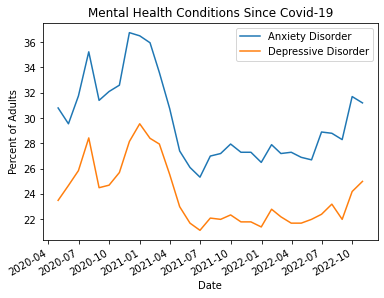

In [6]:
# adjust the format of x tick labels
fig, ax = plt.subplots(1)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
for label in ax.get_xticklabels(which = "major"):
    label.set(rotation = 30, horizontalalignment = "right")

# plot the lines 
plt.plot(health_US.Pct_Anxiety)
plt.plot(health_US.Pct_Depression)

# create labels
plt.xlabel("Date")
plt.ylabel("Percent of Adults")
plt.title("Mental Health Conditions Since Covid-19")
plt.legend(["Anxiety Disorder", "Depressive Disorder"])

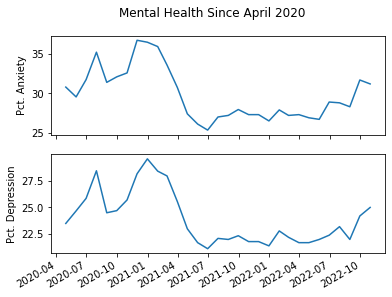

In [7]:
# plot the lines 
fig, ax = plt.subplots(2)
ax[0].plot(health_US.Pct_Anxiety)
ax[1].plot(health_US.Pct_Depression)

# add labels
fig.suptitle("Mental Health Since April 2020")
ax[0].set_ylabel("Pct. Anxiety")
ax[1].set_ylabel("Pct. Depression")

# adjust x-tick labels
for label in ax[1].get_xticklabels(which = "major"):
    label.set(rotation = 30, horizontalalignment = "right")

for ax in fig.get_axes():
    ax.label_outer()

### Test 1: Is there a significant increase in the percentage of US adults experiencing mental health conditions?

In [8]:
## 2-sample z-test to test difference in proportions
n1 = 69316
n2 = 37074
p1 = health_US.Pct_Anxiety[0] / 100
p2 = health_US.Pct_Anxiety[-1] / 100
se = math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
z_score = (p2 - p1) / se
print("Percent Anxiety in 2020-04: %" + str(health_US.Pct_Anxiety[0]))
print("Percent Anxiety in 2022-11: %" + str(health_US.Pct_Anxiety[-1]))
print("2 Sample Z-Test (1-tailed):")
print("Test Statistic: " + str(round(z_score, 4)))
print("P-value: " + str(round(scipy.stats.norm.sf(abs(z_score)), 4)) + "\n")

n1 = 69316
n2 = 37074
p1 = health_US.Pct_Depression[0] / 100
p2 = health_US.Pct_Depression[-1] / 100
se = math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
z_score = (p2 - p1) / se
print("Percent Depression in 2020-04: %" + str(health_US.Pct_Depression[0]))
print("Percent Depression in 2022-11: %" + str(health_US.Pct_Depression[-1]))
print("2 Sample Z-Test (1-tailed):")
print("Test Statistic: " + str(round(z_score, 4)))
print("P-value: " + str(round(scipy.stats.norm.sf(abs(z_score)), 8)))


Percent Anxiety in 2020-04: %30.8
Percent Anxiety in 2022-11: %31.2
2 Sample Z-Test (1-tailed):
Test Statistic: 1.3435
P-value: 0.0896

Percent Depression in 2020-04: %23.5
Percent Depression in 2022-11: %25.0
2 Sample Z-Test (1-tailed):
Test Statistic: 5.4229
P-value: 3e-08


### Discussion: While the second z-test does generate a significant p-value, this result should be taken with caution because the two populations we are comparing are comparing are not independent.

### Test 2: Is the percentage of US adults experiencing mental health issues stationary over time?

In [9]:
## Augmented Dickey Fuller Test to find out if a time-series data is stationary
print("Adfuller for Anxiety:")
print("test statistic: " + str(adfuller(health_US.Pct_Anxiety)[0]))
print("p-value: " + str(adfuller(health_US.Pct_Anxiety)[1]) + "\n")

print("Adfuller for Depression:")
print("test statistic: " + str(adfuller(health_US.Pct_Depression)[0]))
print("p-value: " + str(adfuller(health_US.Pct_Depression)[1]) + "\n")

Adfuller for Anxiety:
test statistic: -1.799238513653371
p-value: 0.38083981592885374

Adfuller for Depression:
test statistic: -1.9174647636244802
p-value: 0.32389026238536545



### Discussion: Both tests yield a p-value greater than 0.05, indicating that both time-series data are non-stationary. In other words their properties are highly dependent on the time at which the data are observed, which is a sign that some other underlying variables are influencing how the data trend over time.

### Plot 2: Number of Monthly New Cases/Deaths

In [10]:
# reorganize data into a plot-friendly format
covid_US = fulldata.groupby("Date")[["New_Cases", "New_Deaths"]].sum()
covid_US.index = pd.to_datetime(covid_US.index) + MonthEnd(0)
covid_US.head()

,New_Cases,New_Deaths
Date,,
2020-04-30,884975,58742
2020-05-31,721264,41193
2020-06-30,850218,23066
2020-07-31,1908607,26332
2020-08-31,1455584,29383


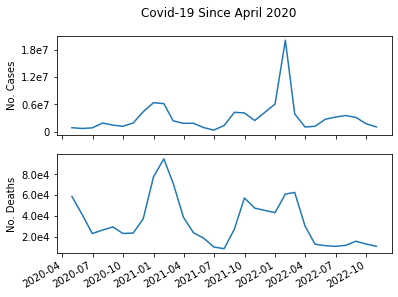

In [11]:
fig, ax = plt.subplots(2)
ax[0].plot(covid_US.New_Cases)
ax[1].plot(covid_US.New_Deaths)

# adjust axis ticks
def tick_formatter(value, tick_number):
    if (value > 0):
        power = round(np.log10(value))
        num = round(value / (10**power), 1)
        return str(num) + "e" + str(power)
    else:
        return 0
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter))

def tick_formatter(value, tick_number):
    num = round(value / 10000, 1)
    return str(num) + "e4"
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter))

# change the number of y ticks
ax[0].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))

# titles
fig.suptitle("Covid-19 Since April 2020")
ax[0].set_ylabel("No. Cases")
ax[1].set_ylabel("No. Deaths")

# adjust the format of x tick labels
for label in ax[1].get_xticklabels(which = "major"):
    label.set(rotation = 30, horizontalalignment = "right")

for ax in fig.get_axes():
    ax.label_outer()

### Plot 3: Correlations between percentage of adults experiencing anxiety/depression and number of covid cases/covid deaths

In [12]:
# reorganize the data into a more plot-friendly format
health_US.index = health_US.index.to_period("M")
covid_US.index = covid_US.index.to_period("M")
covid_health_US = health_US.merge(covid_US, left_index = True, right_index = True)
covid_health_US.head()

,Pct_Anxiety,Pct_Depression,Pct_Anxiety_Or_Depression,New_Cases,New_Deaths
Date,,,,,
2020-04,30.800000,23.500000,35.900000,884975,58742
2020-05,29.550000,24.675000,34.525000,721264,41193
2020-06,31.750000,25.850000,36.500000,850218,23066
2020-07,35.233333,28.433333,40.066667,1908607,26332
2020-08,31.400000,24.500000,36.400000,1455584,29383


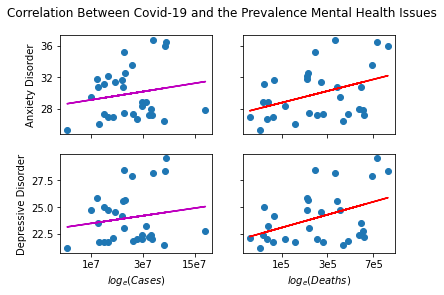

In [13]:
# create a blank sheet consisting of 4 subplots
fig, ax = plt.subplots(2, 2)
  
# title
fig.suptitle("Correlation Between Covid-19 and the Prevalence Mental Health Issues")

# scatter plots
ax[0, 0].scatter(np.log(covid_health_US.New_Cases), covid_health_US.Pct_Anxiety)
ax[1, 0].scatter(np.log(covid_health_US.New_Cases), covid_health_US.Pct_Depression)
ax[0, 1].scatter(np.log(covid_health_US.New_Deaths), covid_health_US.Pct_Anxiety)
ax[1, 1].scatter(np.log(covid_health_US.New_Deaths), covid_health_US.Pct_Depression)

# axis labels
ax[0, 0].set_ylabel("Anxiety Disorder")
ax[1, 0].set_xlabel("$log_{e} (Cases)$")
ax[1, 0].set_ylabel("Depressive Disorder")
ax[1, 1].set_xlabel("$log_{e} (Deaths)$")

# tick labels
def format_anxiety(value, tick_number):
    # find number of multiples of pi/2
    return str(round(np.e**value / 1000000)) + "e7"
ax[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(format_anxiety))

def format_depression(value, tick_number):
    return str(round(np.e**value / 10000)) + "e5"
ax[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(format_depression))

for axi in ax.flat:
    axi.yaxis.set_major_locator(plt.MaxNLocator(4))
    axi.xaxis.set_major_locator(plt.MaxNLocator(4))


# line of best fit
a, b = np.polyfit(np.log(covid_health_US.New_Cases), covid_health_US.Pct_Anxiety, 1)
ax[0, 0].plot(np.log(covid_health_US.New_Cases), a * np.log(covid_health_US.New_Cases) + b, color = "m")

a, b = np.polyfit(np.log(covid_health_US.New_Cases), covid_health_US.Pct_Depression, 1)
ax[1, 0].plot(np.log(covid_health_US.New_Cases), a * np.log(covid_health_US.New_Cases) + b, color = "m")

a, b = np.polyfit(np.log(covid_health_US.New_Deaths), covid_health_US.Pct_Anxiety, 1)
ax[0, 1].plot(np.log(covid_health_US.New_Deaths), a * np.log(covid_health_US.New_Deaths) + b, color = "r")

a, b = np.polyfit(np.log(covid_health_US.New_Deaths), covid_health_US.Pct_Depression, 1)
ax[1, 1].plot(np.log(covid_health_US.New_Deaths), a * np.log(covid_health_US.New_Deaths) + b, color = "r")

# make the plots share x and y axes
for ax in fig.get_axes():
    ax.label_outer()

# plt.savefig('Plot4.png')

### Test 3: Whether the prevalence of mental health issues is significantly related to Covid-19 deaths or cases?

In [14]:
print("TEST 1: Anxiety vs Covid Cases")
result = pearsonr(covid_health_US.Pct_Anxiety, covid_health_US.New_Cases)
print("correlation coefficient: " + str(round(result[0], 4)))
print("p-value: " + str(round(result[1], 4)) + "\n")

print("TEST 2: Anxiety vs Covid Deaths")
result = pearsonr(covid_health_US.Pct_Anxiety, covid_health_US.New_Deaths)
print("correlation coefficient: " + str(round(result[0], 4)))
print("p-value: " + str(round(result[1], 4)) + "\n")

print("TEST 3: Depression vs Covid Cases")
result = pearsonr(covid_health_US.Pct_Depression, covid_health_US.New_Cases)
print("correlation coefficient: " + str(round(result[0], 4)))
print("p-value: " + str(round(result[1], 4)) + "\n")

print("TEST 4: Depression vs Covid Deaths")
result = pearsonr(covid_health_US.Pct_Depression, covid_health_US.New_Deaths)
print("correlation coefficient: " + str(round(result[0], 4)))
print("p-value: " + str(round(result[1], 4)) + "\n")


TEST 1: Anxiety vs Covid Cases
correlation coefficient: 0.0275
p-value: 0.8855

TEST 2: Anxiety vs Covid Deaths
correlation coefficient: 0.4163
p-value: 0.0221

TEST 3: Depression vs Covid Cases
correlation coefficient: 0.0398
p-value: 0.8346

TEST 4: Depression vs Covid Deaths
correlation coefficient: 0.4581
p-value: 0.0109



### Plot 4: Choropleths for percent anxiety and depression, covid deaths, and unemployment rate since Covid-19

In [15]:
# import us states boundaries data 
from urllib.request import urlopen
import json
with urlopen("https://public.opendatasoft.com/explore/dataset/us-state-boundaries/download/?format=geojson&timezone=America/Los_Angeles&lang=en") as response:
    states = json.load(response)

# query data from the periods of interest
april_2020 = fulldata.query("Date == '2020-04'").reset_index(drop = True)
decem_2020 = fulldata.query("Date == '2020-12'").reset_index(drop = True)
sept_2021 = fulldata.query("Date == '2021-09'").reset_index(drop = True)
june_2022 = fulldata.query("Date == '2022-06'").reset_index(drop = True)

In [21]:
# import relevant libraries
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# create a blank sheet consisting of 4 subplots
fig = make_subplots(
    rows = 2, cols = 2,specs = [
        [{"type": "choropleth"}, {"type": "choropleth"}],
        [{"type": "choropleth"}, {"type": "choropleth"}]
    ],
    subplot_titles = ["April 2020", "December 2020", "September 2021", "June 2022"]
)

# add the 4 sub plots
fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = april_2020["Postcode"],
    z = april_2020["Pct_Anxiety_Or_Depression"],
    zmin = 25,
    zmax = 45,
    colorscale = "Blues",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "April, 2020"
), row = 1, col = 1)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = decem_2020["Postcode"],
    z = decem_2020["Pct_Anxiety_Or_Depression"],
    zmin = 25,
    zmax = 45,
    colorscale = "Blues",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "December, 2020"
), row = 1, col = 2)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = sept_2021["Postcode"],
    z = sept_2021["Pct_Anxiety_Or_Depression"],
    zmin = 25,
    zmax = 45,
    colorscale = "Blues",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "April, 2020"
), row = 2, col = 1)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = june_2022["Postcode"],
    z = june_2022["Pct_Anxiety_Or_Depression"],
    zmin = 25,
    zmax = 45,
    colorscale = "Blues",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "December, 2020"
), row = 2, col = 2)

# adjust the scope of the map to only include the US
fig.update_geos(fitbounds = "locations", landcolor = "white", coastlinecolor = "white")

# titie the plot
fig = fig.update_layout(title = "Prevalence of Anxiety & Depressive Symptoms Since Covid-19", 
                  title_x = 0.5, title_font_size = 20)


In [23]:
fig = make_subplots(
    rows = 2, cols = 2,specs = [
        [{"type": "choropleth"}, {"type": "choropleth"}],
        [{"type": "choropleth"}, {"type": "choropleth"}]
    ],
    subplot_titles = ["April 2020", "December 2020", "September 2021", "June 2022"]
)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = april_2020["Postcode"],
    z = april_2020["Pct_Mortality"],
    zmin = 0,
    zmax = fulldata.Pct_Mortality.max(),
    colorscale = "Reds",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "April, 2020"
), row = 1, col = 1)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = decem_2020["Postcode"],
    z = decem_2020["Pct_Mortality"],
    zmin = 0,
    zmax = fulldata.Pct_Mortality.max(),
    colorscale = "Reds",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "December, 2020"
), row = 1, col = 2)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = sept_2021["Postcode"],
    z = sept_2021["Pct_Mortality"],
    zmin = 0,
    zmax = fulldata.Pct_Mortality.max(),
    colorscale = "Reds",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "April, 2020"
), row = 2, col = 1)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = june_2022["Postcode"],
    z = june_2022["Pct_Mortality"],
    zmin = 0,
    zmax = fulldata.Pct_Mortality.max(),
    colorscale = "Reds",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "December, 2020"
), row = 2, col = 2)

fig.update_geos(fitbounds = "locations", landcolor = "white", coastlinecolor = "white")

fig = fig.update_layout(title = "Covid Mortality Rates Since Covid-19", 
                  title_x = 0.5, title_font_size = 20)

In [22]:
fig = make_subplots(
    rows = 2, cols = 2,specs = [
        [{"type": "choropleth"}, {"type": "choropleth"}],
        [{"type": "choropleth"}, {"type": "choropleth"}]
    ],
    subplot_titles = ["April 2020", "December 2020", "September 2021", "June 2022"]
)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = april_2020["Postcode"],
    z = april_2020["Pct_Unemployed"],
    zmin = fulldata.Pct_Unemployed.min(),
    zmax = fulldata.Pct_Unemployed.max(),
    colorscale = "Greens",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "April, 2020"
), row = 1, col = 1)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = decem_2020["Postcode"],
    z = decem_2020["Pct_Unemployed"],
    zmin = fulldata.Pct_Unemployed.min(),
    zmax = fulldata.Pct_Unemployed.max(),
    colorscale = "Greens",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "December, 2020"
), row = 1, col = 2)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = sept_2021["Postcode"],
    z = sept_2021["Pct_Unemployed"],
    zmin = fulldata.Pct_Unemployed.min(),
    zmax = fulldata.Pct_Unemployed.max(),
    colorscale = "Greens",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "April, 2020"
), row = 2, col = 1)

fig.add_trace(trace = go.Choropleth(
    geojson = states,
    locationmode = "USA-states",
    locations = june_2022["Postcode"],
    z = june_2022["Pct_Unemployed"],
    zmin = fulldata.Pct_Unemployed.min(),
    zmax = fulldata.Pct_Unemployed.max(),
    colorscale = "Greens",
    colorbar_title = "% Adults",
    hoverinfo = "location + z",
    name = "December, 2020"
), row = 2, col = 2)

fig.update_geos(fitbounds = "locations", landcolor = "white", coastlinecolor = "white")

fig = fig.update_layout(title = "Unemployment Rates Since Covid-19", 
                  title_x = 0.5, title_font_size = 20)